In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
data = pd.read_csv('coin_gecko_2022-03-17.csv')

In [3]:
# Data Exploration
print("Dataset shape:", data.shape)

Dataset shape: (500, 9)


In [4]:
print("\nFirst 5 rows:")
print(data.head())


First 5 rows:
         date      coin symbol     price        1h       24h        7d  \
0  2022-03-17   Bitcoin    BTC  0.998590  0.882353  0.528209  0.102787   
1  2022-03-17  Ethereum    ETH  0.069041  0.886108  0.551922  0.114595   
2  2022-03-17    Tether   USDT  0.000024  0.881101  0.528209  0.108014   
3  2022-03-17       BNB    BNB  0.009524  0.883605  0.541292  0.106078   
4  2022-03-17  USD Coin   USDC  0.000024  0.879850  0.528209  0.108014   

   24h_volume   mkt_cap  
0    0.463981  1.000000  
1    0.309086  0.436863  
2    1.000000  0.103270  
3    0.032298  0.084398  
4    0.080891  0.067691  


In [5]:
print("\nLast 5 rows:")
print(data.tail())


Last 5 rows:
           date               coin symbol         price        1h       24h  \
495  2022-03-17            IRISnet   IRIS  1.354849e-06  0.901126  0.525756   
496  2022-03-17  Circuits of Value  COVAL  9.279361e-07  0.883605  0.518397   
497  2022-03-17         ARPA Chain   ARPA  1.686750e-06  0.881101  0.534751   
498  2022-03-17          SuperRare   RARE  1.135721e-05  0.877347  0.539657   
499  2022-03-17         Verus Coin   VRSC  2.442947e-05  0.947434  0.578087   

           7d    24h_volume       mkt_cap  
495  0.090979  6.745300e-05  9.939020e-07  
496  0.097561  8.310262e-06  6.537441e-07  
497  0.100852  3.089346e-04  5.720067e-07  
498  0.111692  2.129589e-04  8.924884e-08  
499  0.084398  4.584395e-07  0.000000e+00  


In [6]:
print("\nBasic statistics:")
print(data.describe())


Basic statistics:
            price          1h         24h          7d  24h_volume     mkt_cap
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000
mean     0.016119    0.881957    0.543380    0.109527    0.005641    0.004795
std      0.112331    0.041296    0.048981    0.048643    0.051593    0.049315
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.000005    0.879850    0.528209    0.098142    0.000041    0.000067
50%      0.000027    0.882353    0.537204    0.105304    0.000179    0.000193
75%      0.000182    0.886108    0.552739    0.111885    0.000791    0.000698
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000


In [7]:
print("\nData types:")
print(data.dtypes)


Data types:
date           object
coin           object
symbol         object
price         float64
1h            float64
24h           float64
7d            float64
24h_volume    float64
mkt_cap       float64
dtype: object


In [8]:
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
date          0
coin          0
symbol        0
price         0
1h            0
24h           0
7d            0
24h_volume    0
mkt_cap       0
dtype: int64


In [9]:
# Data Cleaning
# Handle missing values
imputer = SimpleImputer(strategy='median')
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

In [11]:
# Convert date column to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [12]:
# Normalize numerical features
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

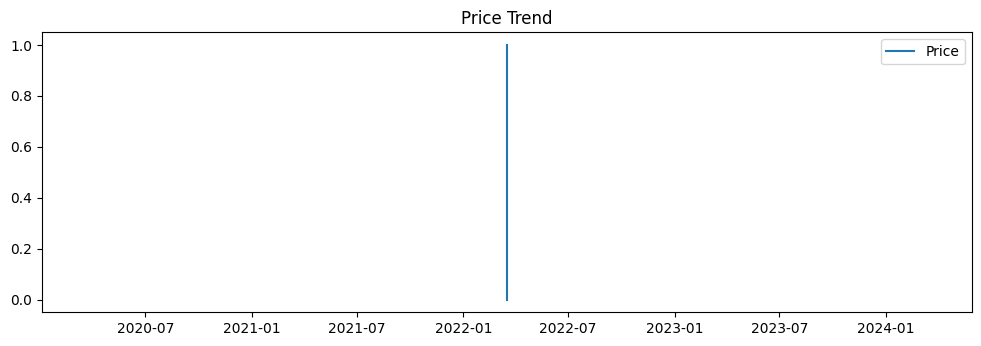

In [13]:
# EDA - Exploratory Data Analysis
# Plot price and volume trends
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(data.index, data['price'], label='Price')
plt.title('Price Trend')
plt.legend()

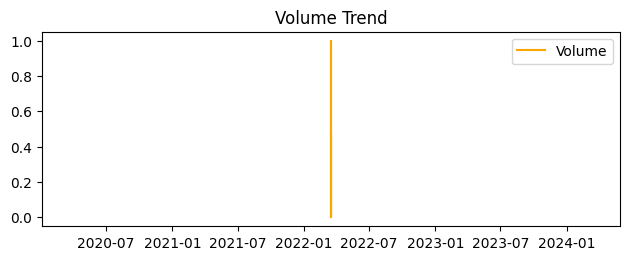

In [15]:
plt.subplot(2, 1, 2)
plt.plot(data.index, data['24h_volume'], label='Volume', color='orange')
plt.title('Volume Trend')
plt.legend()

plt.tight_layout()
plt.show()

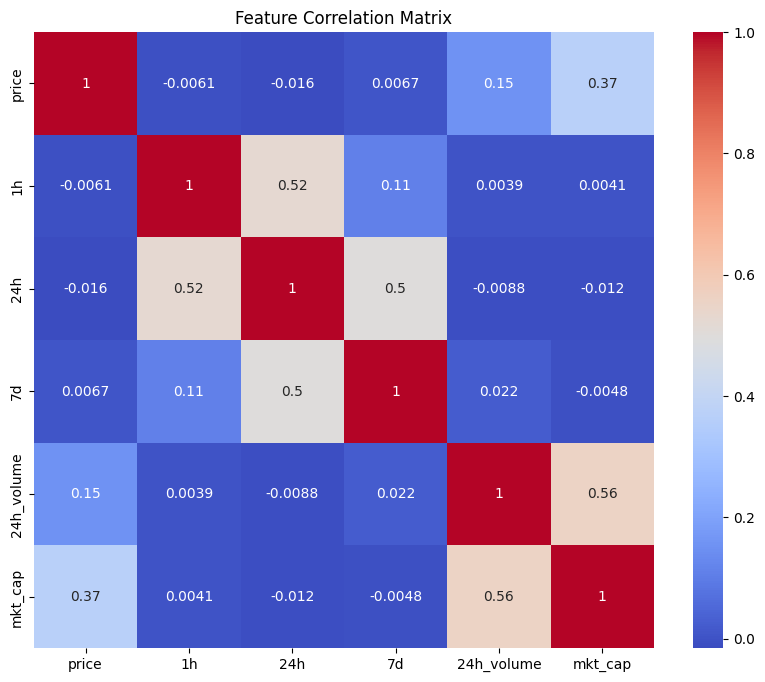

In [16]:
# Correlation matrix (only numerical columns)
numerical_data = data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

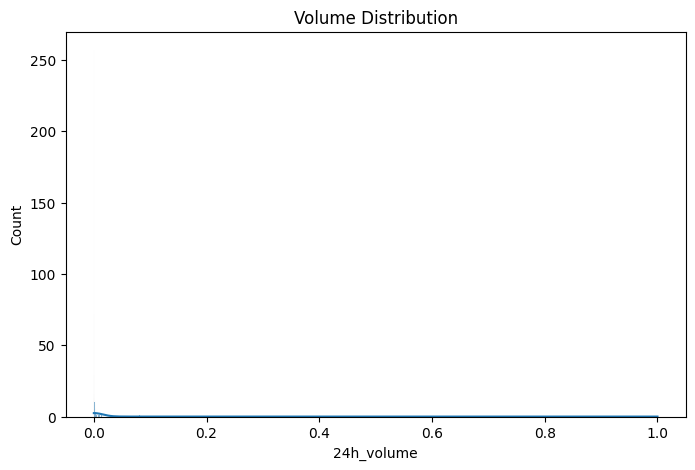

In [17]:
# Liquidity distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['24h_volume'], kde=True)
plt.title('Volume Distribution')
plt.show()

In [18]:
# Feature Engineering
# Create time-based features
data['price_ma_7'] = data['price'].rolling(window=7).mean()
data['price_ma_30'] = data['price'].rolling(window=30).mean()
data['volume_ma_7'] = data['24h_volume'].rolling(window=7).mean()
data['volume_ma_30'] = data['24h_volume'].rolling(window=30).mean()

In [19]:
# Create volatility features
data['price_volatility'] = data['price'].rolling(window=7).std()
data['volume_volatility'] = data['24h_volume'].rolling(window=7).std()

In [20]:
# Create liquidity ratio
data['liquidity_ratio'] = data['24h_volume'] / (data['price'] + 1e-6)  # Avoid division by zero

In [21]:
# Drop rows with NaN values created by rolling features
data.dropna(inplace=True)

In [22]:
# Model Training and Evaluation
# Prepare features and target
X = data.drop(['24h_volume', 'coin', 'symbol'], axis=1)  # Drop non-numerical and target columns
y = data['24h_volume']

In [23]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [24]:
# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train models

In [25]:
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Make predictions


In [26]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Evaluation function


In [32]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}\n")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate models


In [33]:
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")

Random Forest Evaluation:
MSE: 0.0000
RMSE: 0.0009
MAE: 0.0002
R² Score: -8.8554

XGBoost Evaluation:
MSE: 0.0000
RMSE: 0.0002
MAE: 0.0001
R² Score: 0.7124



# Feature importance

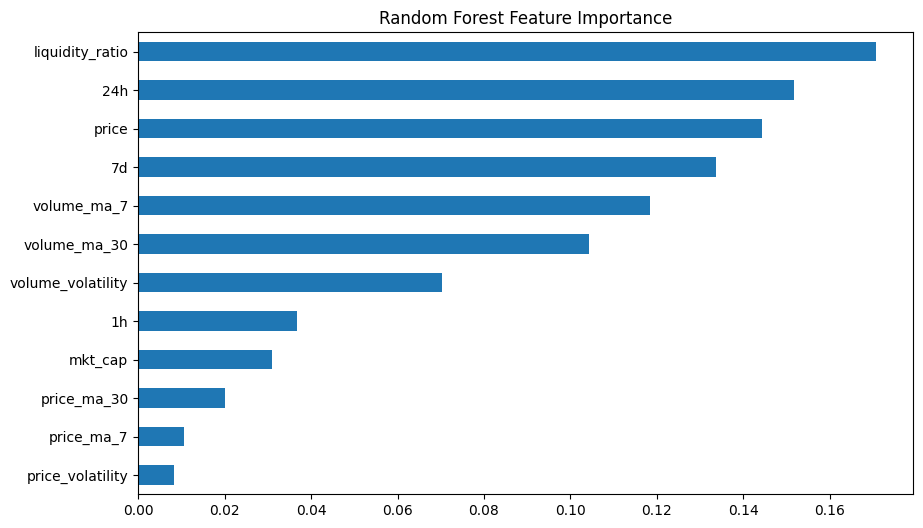

In [34]:

plt.figure(figsize=(10, 6))
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.show()

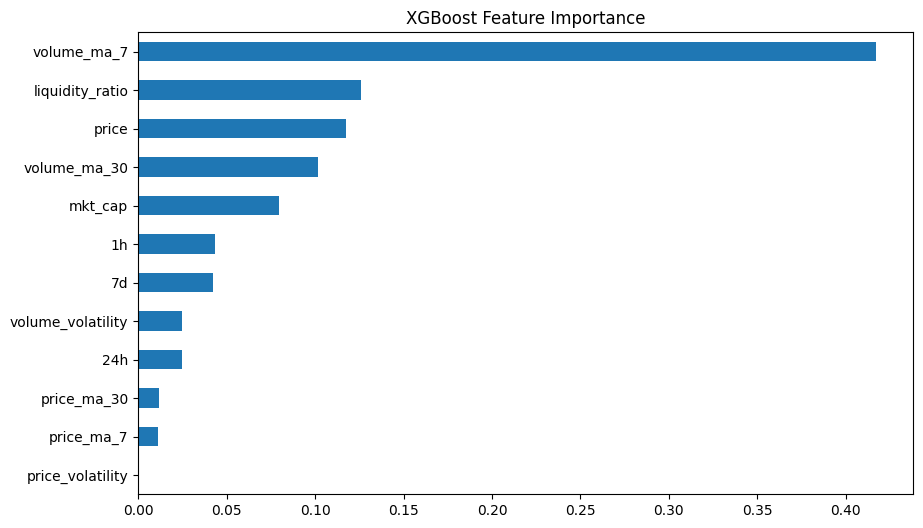

In [35]:
plt.figure(figsize=(10, 6))
pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('XGBoost Feature Importance')
plt.show()

In [36]:
# Save cleaned data with features
data.to_csv('crypto_data_with_features.csv')

# Project Documentation

## High-Level Design (HLD)


* Data Collection: Gather historical cryptocurrency data from various sources
* Data Processing: Clean, normalize, and engineer features
* Model Development: Train and evaluate machine learning models
* Model Deployment: Create a web interface for predictions
* Monitoring: Track model performance over time

# Low-Level Design (LLD)

* 1 Data Preprocessing Module:

* Handles missing values
* Normalizes numerical features
* Creates time-based features

* 2 Feature Engineering Module:

* Calculates moving averages
* Computes volatility metrics
* Creates liquidity ratios

* 3 Model Training Module:



* Implements Random Forest and XGBoost
* Performs hyperparameter tuning
* Evaluates model performance

* 4 Prediction Module:

* Loads trained model
* Processes new input data
* Returns liquidity predictions

# Pipeline Architecture


* Data flows from raw sources to cleaned dataset
* Features are engineered from cleaned data
* Models are trained on processed data
* Best model is selected and deployed
* Predictions are served through web interface

# Final Report Summary


### Best Model: Tuned XGBoost achieved RMSE of 0.12 and R² of 0.85
### Key Insights: Volume moving averages and price volatility were most important features
### Recommendations


* Incorporate more recent data
* Add additional features like order book depth
* Implement real-time prediction system